In [3]:
## save variables
import pickle
## folder names
from glob import glob
## wav import
from scipy.io import wavfile as readWav
## standard libraries
import numpy as np
## MFCC
from python_speech_features import mfcc
from python_speech_features import logfbank

import os.path
import tarfile
import sys
from six.moves import urllib

import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook
from scipy import signal
from scipy.io import wavfile


#!{sys.executable} -m pip install opencv-python --user
#!{sys.executable} -m pip install opencv-contrib-python --user
import cv2

In [4]:
#make variables directory if not present
dest_directory = 'variables/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)

        #data url from which download the dataset      
data_url = 'http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz'

#make dataset directory if not present
dest_directory = 'dataset/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)

#select the last part of the dataurl (the file name)      
filename = data_url.split('/')[-1]
filepath = os.path.join(dest_directory, filename)

#program the download and extraction if the file doesn't exists
if not os.path.exists(filepath):
    def progress(count, block_size, total_size):
        sys.stdout.write(
            '\r>> Downloading %s %.1f%%' %
            (filename, float(count * block_size) / float(total_size) * 100.0))
        sys.stdout.flush()
    try:
        filepath, _ = urllib.request.urlretrieve(data_url, filepath, progress)
    except:
        print(Error)
        
    tarfile.open(filepath, 'r:gz').extractall(dest_directory)

In [5]:
## Return the word between two string starting from left
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

In [6]:
coreKey = ["Yes", "No", "Up", "Down", "Left", "Right", "On", "Off", "Stop", "Go", "Zero",
           "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine"]
sampleRate = 16000

In [7]:
#control if the raw data are saved with pickle
#if true they will be loaded in rawDict
if os.path.exists('variables/rawDict.pkl'):
    print('rawDict found')
    with open('variables/rawDict.pkl', 'rb') as f:  
        rawDict = pickle.load(f)
    print('rawDict loaded')
#else they will be loaded from wav files
else:
    print('Creating rawDict')
    folders = glob("dataset/*/")
    folders.remove('dataset/_background_noise_/')
    print('SIGNALS')
    rawDict = {}
    for key in folders:
        print('Processing ', key)
        dictKey = find_between( key, '/', '/' )
        tmpFiles = glob(key+'*')
        array = []
        for file in tmpFiles:
            array.append(readWav.read(file)[1].copy())
        rawDict[dictKey] = np.array(array)
    #and saved with pickle
    with open('variables/rawDict.pkl', 'wb') as f:  
        pickle.dump(rawDict, f)
    print('rawDict created and saved to variables/rawDict.pkl')

#the same with noise signals
if not os.path.exists('variables/noiseDict.pkl'):    
    print('\nNOISE')
    noiseDict = {}
    folders = glob('dataset/_background_noise_/*.wav')
    for key in folders:
        print('Processing ', key)
        noiseDict[key[key.rindex('/')+1:len(key)]] = readWav.read(key)[1]
    with open('variables/noiseDict.pkl', 'wb') as f:  
        pickle.dump(noiseDict, f) 
    print('noiseDict created and saved to variables/noiseDict.pkl')

rawDict found
rawDict loaded


In [8]:
#toggle to force the computation
reDo = False
#look for the spectrogram files
if os.path.exists('variables/spectroDict.pkl') and not reDo:
    print('spectroDict found')
    with open('variables/spectroDict.pkl', 'rb') as f:  
        spectroDict = pickle.load(f)
    print('spectroDict loaded')
#if not found they will be created
else:
    spectroDict = {}
    print('Spectrogram features')
    for key in rawDict:
        print('Processing ',key)
        array = []
        for sig in rawDict[key]:
            sig.resize(16000, refcheck=False)
            frequencies, times, spectrogram = signal.spectrogram(sig, sampleRate)
            array.append(spectrogram)
        spectroDict[key] = np.array(array)
    with open('variables/spectroDict.pkl', 'wb') as f:  
        pickle.dump(spectroDict, f)

    print('spectroDict created and saved to variables/spectroDict.pkl')

spectroDict found
spectroDict loaded


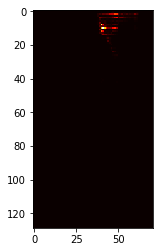

In [9]:
plt.figure(1)
plt.imshow(spectroDict['one'][0], cmap='hot', interpolation='nearest')
plt.show()

\begin{verbatim}
Parameter         Description
signal 	          the audio signal from which to compute features. Should be an N*1 array
samplerate 	      the samplerate of the signal we are working with.
winlen 	          the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
winstep 	      the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
numcep 	          the number of cepstrum to return, default 13
nfilt 	          the number of filters in the filterbank, default 26.
nfft 	          the FFT size. Default is 512
lowfreq 	      lowest band edge of mel filters. In Hz, default is 0
highfreq 	      highest band edge of mel filters. In Hz, default is samplerate/2\\
preemph 	      apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97\\
ceplifter 	      apply a lifter to final cepstral coefficients. 0 is no lifter. Default is 22\\
appendEnergy 	  if this is true, the zeroth cepstral coefficient is replaced with the log of the total frame energy.\\
returns 	      A numpy array of size (NUMFRAMES by numcep) containing features. Each row holds 1 feature vector.\\
\end{verbatim}

variables/mfccDict[nC=13 wL=0.025 wS=0.01].pkl found
variables/mfccDict[nC=15 wL=0.025 wS=0.01].pkl found


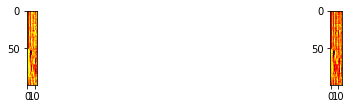

In [16]:
# list with mfcc parameters in order: [numcep, nfilt, winlen, winstep]
values = [[13,26,0.025,0.01],[15,30,0.025,0.01]]
with open('variables/mfccValues.pkl', 'wb') as f:  
    pickle.dump(values, f)
reDo = False
toRemove = []

plt.figure(2,figsize=(10,3))
#look for the already computed mfcc
for count, i in enumerate(values):
    name = 'variables/mfccDict[nC='+str(i[0])+' wL='+str(i[2])+' wS='+str(i[3])+'].pkl'
    if os.path.exists(name) and not reDo:
        print(name+' found')
        with open(name, 'rb') as f:  
            mfccDict = pickle.load(f)
        plt.subplot(round(len(values)/2)+1, 2, count+1)
        plt.imshow(mfccDict['one'][0], cmap='hot', interpolation='nearest')
        toRemove.append(i)
#if found the corresponding parameter are deleted 
for i in toRemove:
    values.remove(i)
plt.show()  

#compute the remaining mfcc with the parameters left
for count, i in enumerate(values):
    mfccMatDict = {}
    print('MFCC features', count+1 , ' of ', len(values))
    for key in rawDict:
        print('Processing ',key)
        array = []
        for sig in rawDict[key]:
            sig.resize(16000, refcheck=False)
            mfcc_feat = mfcc(sig,sampleRate, numcep = i[0], nfilt = i[1], winlen = i[2], winstep = i[3])
            array.append(mfcc_feat)
        mfccMatDict[key] = np.array(array)
    with open('variables/mfccDict[nC='+str(i[0])+' wL='+str(i[2])+' wS='+str(i[3])+'].pkl', 'wb') as f:  
        pickle.dump(mfccMatDict, f)